Analyse Préliminaire IRM_Marche
--
Parcellation en 444 regions (BASC Atlas)

Classification : SVM Linéaire

Sujets sains (MY,AF,BA,BR)

Classification Marche Confortable VS Rest
--
Cross validée par run (9)

In [48]:
import numpy as np
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.datasets import load_mni152_brain_mask,load_mni152_template
from sklearn.externals.joblib import Memory
from nilearn.plotting import plot_stat_map
%matplotlib inline

In [49]:
names='af','ba','br','my'

scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
pipeline = Pipeline([('scale', scaler),('svm', svm)])


block=np.loadtxt('D:/irm_marche/block.txt','int')
label=np.loadtxt('D:/irm_marche/label.txt','S12')
condition_mask = np.logical_or(label == b'restconf', label == b'conf')
y = label[condition_mask]
block_cond = block[condition_mask]
cv = LeaveOneLabelOut(block_cond)

for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi_cond=roi[condition_mask]



    classifiers_scores = cross_val_score(
                                pipeline, roi_cond, y,cv=cv)
    print n,classifiers_scores.mean()

af 0.658088235294
ba 0.639705882353
br 0.727532679739
my 0.705882352941


Visualisation des poids du SVM (regions qui permettent la classification): sur MY qui a les meilleures performances

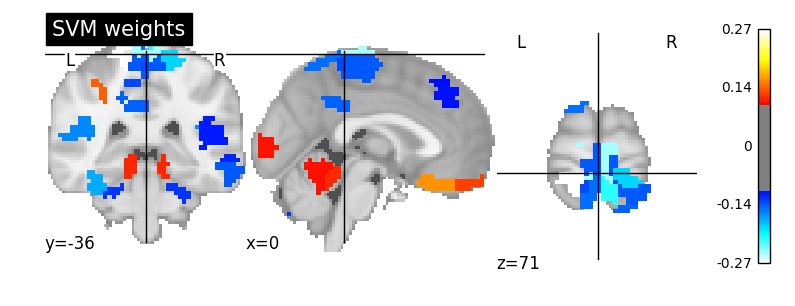

In [52]:
n='my'
roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
roi=np.load(roi_name)['roi']
roi_cond=roi[condition_mask]


mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()
pipeline.fit(roi_cond,y)
coef = pipeline.named_steps['svm'].coef_
weight_img = masker.inverse_transform(coef)
plot_stat_map(weight_img, title='SVM weights',threshold=0.1
)


Classification Imagination VS Rest
--
Cross validée par run (9)

In [53]:
condition_mask = np.logical_or(label == b'restimag', label == b'imag')
y = label[condition_mask]
block_cond = block[condition_mask]
cv = LeaveOneLabelOut(block_cond)

for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi_cond=roi[condition_mask]



    classifiers_scores = cross_val_score(
                                pipeline, roi_cond, y,cv=cv)
    print n,classifiers_scores.mean()

af 0.773284313725
ba 0.793300653595
br 0.834150326797
my 0.761029411765


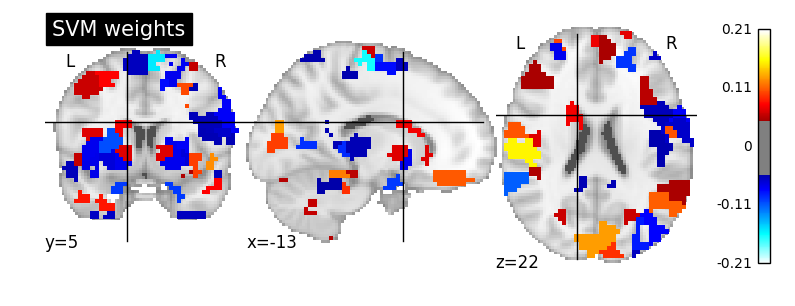

In [58]:
n='my'
roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
roi=np.load(roi_name)['roi']
roi_cond=roi[condition_mask]


mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()
pipeline.fit(roi_cond,y)
coef = pipeline.named_steps['svm'].coef_
weight_img = masker.inverse_transform(coef)
plot_stat_map(weight_img, title='SVM weights',threshold=0.05
)

Classification sur differentes modalités : Entrainement (Stimulation vs Rest) et Test (Imagination vs Rest) 
--


Entrainement sur Marche Confortable+Marche Forcée + Pied Droit
--
(si on apprend sur Marche Destructurée on observe des scores à 0.3 ce qui est bizarre...

In [54]:
labelgen=np.loadtxt('D:/irm_marche/label_reststim.txt','S12')

for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    
    roi_train=np.append(roi[0:150],roi[450:750],axis=0) 
    y_train=np.append(labelgen[0:150],labelgen[450:750],axis=0)

    roi_test=roi[300:450]
    y_test=labelgen[300:450]

    pipeline.fit(roi_train,y_train)
    prediction = pipeline.predict(roi_test)
    score=pipeline.score(roi_test,y_test)
    print n,score

af 0.546666666667
ba 0.48
br 0.633333333333
my 0.573333333333


Entrainement seulement sur "Marche Confortable"
--

In [60]:
for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    
    roi_train=roi[0:150]
    y_train=labelgen[0:150]

    roi_test=roi[300:450]
    y_test=labelgen[300:450]

    pipeline.fit(roi_train,y_train)
    prediction = pipeline.predict(roi_test)
    score=pipeline.score(roi_test,y_test)
    print n,score

af 0.586666666667
ba 0.48
br 0.473333333333
my 0.586666666667


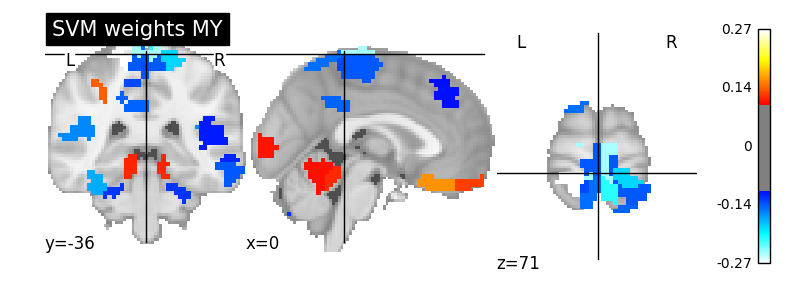

In [61]:
# Meme coeficients que 1er graphique, vu qu'on a appris sur les meme données.
coef = pipeline.named_steps['svm'].coef_
weight_img = masker.inverse_transform(coef)
plot_stat_map(weight_img, title='SVM weights MY',threshold=0.1
)